In [148]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc

from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, classification_report

In [158]:
# Define model
class Perceptron(torch.nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.layer = torch.nn.Linear(input_size, 8)
        self.layer2 = torch.nn.Linear(8, 8)
        self.sigmoid = torch.nn.Sigmoid()
        self.layer3 = torch.nn.Linear(8, 1)
        self.sigmoid3 = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid3(x)
        return x

In [203]:
# Define model
class BrokenPerceptron(torch.nn.Module):
    def __init__(self, input_size):
        super(BrokenPerceptron, self).__init__()
        self.layer = torch.nn.Linear(input_size, 1)
        self.layer2 = torch.nn.Linear(1, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.layer3 = torch.nn.Linear(1, 1)
        self.sigmoid3 = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid3(x)
        return x


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.28      0.43       100
         1.0       0.57      0.97      0.72       100

    accuracy                           0.62       200
   macro avg       0.74      0.62      0.57       200
weighted avg       0.74      0.62      0.57       200

Accuracy: 0.6250
F1 Score: 0.7212
ROC AUC: 0.5207


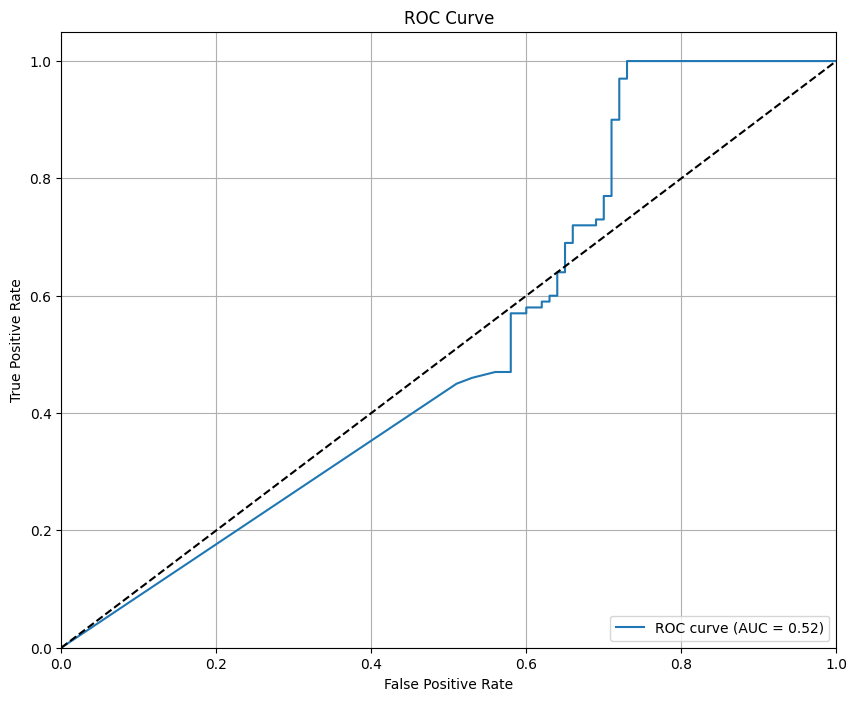

In [209]:
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Initialize model, loss, and optimizer
model = BrokenPerceptron(X_train.shape[1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 500
losses = []

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    losses.append(loss.item())
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()

with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred.squeeze() > 0.5).float()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test.numpy(), y_pred.squeeze().numpy())
    roc_auc = auc(fpr, tpr)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class))

    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [ ]:
from hessian import HessianCalculator
